In [26]:
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, adjusted_rand_score,
                             calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)

In [27]:
'''
mean是正态分布的mean，scale是sigma
'''
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Encoder, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.GELU()
             
        )
        self.mean = torch.nn.Linear(hidden_dim, output_dim)
        self.scale = torch.nn.Sequential(torch.nn.Linear(hidden_dim, output_dim), torch.nn.Softplus())
        
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                    torch.nn.init.kaiming_uniform_(m.weight)
                    
    def forward(self, x):
        q = self.net(x)
        return self.mean(q), self.scale(q)
    
class Decoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Decoder, self).__init__()
        self.lam = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.Softplus()
        )
        
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                    torch.nn.init.kaiming_uniform_(m.weight)

    def forward(self, x):
        return self.lam(x) + 1e-15

In [28]:
def kl_term(mean, scale):
    """
    KL divergence between N(mean, scale) and N(0, 1)
    mean.shape(cells,hidden_dim)
    scale.shape(cells.hidden_dim)
    在隐空间上计算KL
    """
    return .5 * (1 - 2 * torch.log(scale) + (mean * mean + scale * scale))

def pois_llik(x, mean):
    """Return the log likelihood of x distributed as Poisson"""
    return x * torch.log(mean) - mean - torch.lgamma(x + 1)

def nb_llik(x, mean, inv_disp):
    """
    Return the log likelihood of x distributed as NB
    See Hilbe 2012, eq. 8.10
    mean - mean (> 0)
    inv_disp - inverse dispersion (> 0)
    """
    return (x * torch.log(mean / inv_disp) -
            x * torch.log(1 + mean / inv_disp) -
            inv_disp * torch.log(1 + mean / inv_disp) +
            torch.lgamma(x + inv_disp) -
            torch.lgamma(inv_disp) -
            torch.lgamma(x + 1))

def zinb_llik(x, mean, inv_disp, logodds):
    """Return the log likelihood of x distributed as ZINB
    See Hilbe 2012, eq. 11.12, 11.13
    mean - mean (> 0)
    inv_disp - inverse dispersion (> 0)
    logodds - logit point mass weight
    """
    # Important identities:
    # log(x + y) = log(x) + softplus(log(y) - log(x))
    # log(sigmoid(x)) = -softplus(-x)
    softplus = torch.nn.functional.softplus
    case_zero = -softplus(-logodds) + softplus(nb_llik(x, mean, inv_disp) - logodds)
    case_non_zero = -softplus(logodds) + nb_llik(x, mean, inv_disp)
    return torch.where(torch.lt(x, 1), case_zero, case_non_zero)

In [17]:
class PVAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        #self.cluster_center = torch.nn.Parameter(torch.Tensor(nclusters, 64))
        
        self.alpha = 1

    def loss(self, x):
        mean, scale = self.encoder.forward(x)
        kl = torch.sum(kl_term(mean, scale), dim=1)#return(1,cells)每一个样本的embedding对应的kl, 
        qz = torch.distributions.Normal(mean, scale).rsample()#可以添加n_samples进行多次采样，qz.shape (cells, latent_dim)
        lam = self.decoder.forward(qz)#返回的是(cells,genes)
        error = torch.sum(pois_llik(x, lam), dim=1)
        loss = -torch.mean(error - kl)
        return loss
    
    def soft_con(self, x, soft_label, tau=0.2):
        
        x = F.normalize(x)
        
        similarity_matrix = F.cosine_similarity(x.unsqueeze(1), x.unsqueeze(0), dim=2)#相似度矩阵
        
        soft_class = torch.mm(soft_label, soft_label.T)#对应相乘得到每两个样本分到同一类的概率
        no_soft_class = 1 - soft_class#得到每两个样本不分到同一类的概率
        mask_duijiao = (torch.ones(x.shape[0], x.shape[0]) - torch.eye(x.shape[0])).to(device)#mask对角矩阵
        
        soft_similarity = soft_class * similarity_matrix
        no_soft_similarity = no_soft_class * similarity_matrix
        
        fenzi = torch.exp((mask_duijiao * soft_similarity + torch.eye(x.shape[0]).to(device)) / tau) 
        fenmu = torch.exp((mask_duijiao * no_soft_similarity + torch.eye(x.shape[0]).to(device)) / tau) 
        
        loss = -torch.log(torch.div(fenzi, fenmu))
        loss = torch.sum(torch.sum(loss, dim=1)) / (2*x.shape[0])
        
        return loss
    
    def label_filter(self, mean, soft_label):
        index = []
        for i in range(soft_label.shape[0]):
            if soft_label[i].max() >= 0.4:
                index.append(i)
        mean = pd.DataFrame(mean.detach().cpu().numpy())
        soft_label = pd.DataFrame(soft_label.detach().cpu().numpy())
        mean = torch.tensor(np.array(mean.loc[index])).to(device)
        soft_label = torch.tensor(np.array(soft_label.loc[index])).to(device)
        
        #print(len(index))
        return mean, soft_label
        
        
    def cluster_loss(self, x):
        mean, scale = self.encoder.forward(x)
        kl = torch.sum(kl_term(mean, scale), dim=1)#return(1,cells)每一个样本的embedding对应的kl, 
        qz = torch.distributions.Normal(mean, scale).rsample()#可以添加n_samples进行多次采样，qz.shape (cells, latent_dim)
        lam = self.decoder.forward(qz)#返回的是(cells,genes)
        error = torch.sum(pois_llik(x, lam), dim=1)
        
        soft_label = self.soft_assign(mean)#概率距离转化的soft_label
        #mean, soft_label = self.label_filter(mean, soft_label)
        contrastive_loss = self.soft_con(mean, soft_label)
        
        loss = -torch.mean(error - kl) + contrastive_loss * 0.1
        
        return loss
    
    def soft_assign(self, z):
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_center)**2, dim=2) / self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q
    
    def pre_train(self, max_epoch=3000, patience=15, verbose=False):

        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4, weight_decay=0.00001)
         
        bad_count = 0
        best_test_loss = 10000
        best_model = None
        
        for epoch in range(max_epoch):
            
            self.train()
            for batch_idx, x in enumerate(dataloader_pre):
                
                optimizer.zero_grad()
                loss = self.loss(x)
                loss.backward()
                optimizer.step()
            
            self.eval()
            test_loss = self.loss(adata_test)
            
            if test_loss.item() < best_test_loss:
                best_test_loss = test_loss.item()
                bad_count = 0 
                best_model = copy.deepcopy(self)
            
            else:
                bad_count += 1
                
            if bad_count >= patience:
                break    
                    
            if verbose:
                print(f'[epoch {epoch}] test_elbo = {test_loss}')
        
        self = copy.deepcopy(best_model)
    
        return self
    
    def fit(self, labels, max_epoch, verbose=False):
        
        self.to(device)
                
        self.pre_train()#预训练得到聚类中心
        
        kmeans_pred = kmeans.fit_predict(self.encoder(adata_full)[0].detach().cpu())
        #self.cluster_center.data.copy_(torch.tensor(kmeans.cluster_centers_, dtype=torch.float32))
        self.cluster_center = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
        ari_pre = round(adjusted_rand_score(labels, kmeans_pred), 4)
        
        print(f'pre_train_ari = {ari_pre}')
        
        
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-5, weight_decay=0.0001)
        #lr_s=StepLR(optimizer,step_size=10, gamma=0.95)
        for epoch in range(1, max_epoch+1):
            self.train()
            
            if epoch %20 == 0:
                kmeans_pred = kmeans.fit_predict(self.encoder(adata_full)[0].detach().cpu())
                self.cluster_center = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
                ari = round(adjusted_rand_score(labels, kmeans_pred), 4)
                print(f'recluster ari = {ari}')
                
            for x in dataloader_full:
                
                optimizer.zero_grad()
                loss = self.cluster_loss(x)
                loss.backward()
                optimizer.step()
                
            #lr_s.step()
          
        return self
            
    @torch.no_grad()
    def predict(self, x):
        x = x.float().to(device)
        mean, scale = self.encoder.forward(x)
        mu = self.decoder.forward(mean)
        return mu, mean

    @torch.no_grad()
    def denoise(self, x):
        return self.predict(x)
    
class NBVAE(PVAE):
    def __init__(self, input_dim, latent_dim, disp_by_gene=True):
        """Initialize the VAE parameters
        disp_by_gene - if True, model one dispersion parameter per gene
        """
        # Important: only μ is a neural network output, so we can actually reuse
        # the entire PVAE.
        super().__init__(input_dim, latent_dim)
        if disp_by_gene:
            # Important: shape needs to be correct to broadcast
            self.log_inv_disp = torch.nn.Parameter(torch.zeros([1, input_dim]))
        else:
            self.log_inv_disp = torch.nn.Parameter(torch.zeros([1]))
    
    def loss(self, x):
        mean, scale = self.encoder.forward(x)
        kl = torch.sum(kl_term(mean, scale), dim=1)#return(1,cells)每一个样本的embedding对应的kl
        qz = torch.distributions.Normal(mean, scale).rsample()#qz.shape (cells, latent_dim)
        mu = self.decoder.forward(qz)
        error = torch.sum(nb_llik(x, mu, torch.exp(self.log_inv_disp)), dim=1)
        loss = -torch.mean(error - kl)
        return loss

    @torch.no_grad()
    def denoise(self, x):
        x = x.float().to(device)
        mu, embedding = self.predict(x)
        # E[lam | g] = E_z[E[lam | z, g]]
        lam = (x + torch.exp(self.log_inv_disp)) / (torch.exp(self.log_inv_disp) / mu + 1)
        lam = lam.cpu()
        return lam.numpy(), embedding
    
class ZINBVAE(NBVAE):
    def __init__(self, input_dim, latent_dim, disp_by_gene=True, logodds_by_gene=True):
        # Important: only μ is a neural network output, and we still need
        # log_inv_disp, so we can actually reuse the entire NBVAE.
        super().__init__(input_dim, latent_dim, disp_by_gene=disp_by_gene)
        if logodds_by_gene:
            self.logodds = torch.nn.Parameter(torch.zeros([1, input_dim]))
        else:
            self.logodds = torch.nn.Parameter(torch.zeros([1]))
            
    def loss(self, x):
        mean, scale = self.encoder.forward(x)
        kl = torch.sum(kl_term(mean, scale), dim=1)#return(1,cells)每一个样本的embedding对应的kl
        qz = torch.distributions.Normal(mean, scale).rsample()#可以添加n_samples进行多次采样，qz.shape (cells, latent_dim)
        mu = self.decoder.forward(qz)
        error = torch.sum(zinb_llik(x, mu, torch.exp(self.log_inv_disp), self.logodds), dim=1)
        loss = -torch.mean(error - kl)
        
        return loss
    
    @torch.no_grad()
    def denoise(self, x):
        x = x.float().to(device)
        mu, embedding = self.predict(x)
        # E[lam | g] = E_z[E[lam | z, g]]
        lam = torch.sigmoid(-self.logodds) * (x + torch.exp(self.log_inv_disp)) / (torch.exp(self.log_inv_disp) / mu + 1)
        lam = lam.cpu()
        return lam.numpy(), embedding

In [18]:
dataset = [
    '../../data/Young.h5ad',
    '../../data/mouse_ES_cell.h5ad',
    '../../data/mouse_bladder.h5ad',
    '../../data/worm_neuron.h5ad',
    '../../data/QS_Trachea.h5ad',
    '../../data/10X_PBMC.h5ad',
    '../../data/Romanov.h5ad',
    '../../data/QS_Diaphragm.h5ad',
    '../../data/QS_Limb_Muscle.h5ad',
    '../../data/QS_Lung.h5ad'
    ]

In [29]:
dataset = [
    '../../data/mouse_ES_cell.h5ad',
    ]

In [30]:
result = []
device = torch.device('cuda:1')
for i in dataset:
    adata = sc.read_h5ad(i)
    sc.pp.filter_cells(adata, min_genes=1)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_cells(adata, min_counts=1)
    adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000, subset=True)
    
    true_label = np.array(adata.obs.cell_label)
    nclusters = (np.unique(true_label).max() - np.unique(true_label).min() + 1).astype(int)
    print('Successfully preprocessed {} cells and {} genes in {} clusters.'.format(adata.n_obs, adata.n_vars, nclusters))

    ari_klist = []
    for j in range(1):
        kmeans = KMeans(n_clusters=nclusters, init="k-means++",random_state=21)
        
        adata_full = torch.tensor(adata.X).to(device)
        dataloader_full = DataLoader(adata_full, batch_size=1024, shuffle=True)
        
        adata_train, adata_test = train_test_split(torch.tensor(adata.X), test_size=0.05)
        adata_train = adata_train.to(device)
        adata_test = adata_test.to(device)
        dataloader_pre = DataLoader(adata_train, batch_size=1024, shuffle=True)        
               
        model = ZINBVAE(input_dim=adata.X.shape[1], latent_dim=64).fit(labels=true_label, max_epoch=100, verbose=True)
        mu, embedding = model.denoise(torch.tensor(adata.X))
        
        kmeans = KMeans(n_clusters=nclusters, init="k-means++",random_state=21)
        kmeans_pred = kmeans.fit_predict(embedding.cpu())
        ari_k = round(adjusted_rand_score(true_label, kmeans_pred), 4)
        ari_klist.append(ari_k)
        print(ari_k)
        
    ari = sum(ari_klist)/len(ari_klist)
    result.append(ari)
    print(result)
    
    print('------------{} is Done'.format(i))

Successfully preprocessed 2717 cells and 3000 genes in 4 clusters.
pre_train_ari = 0.8191
recluster ari = 0.8071
recluster ari = 0.8097
recluster ari = 0.8106
recluster ari = 0.8117
recluster ari = 0.8184
0.8078
[0.8078]
------------../../data/mouse_ES_cell.h5ad is Done


/home/dqw_zbw/anaconda3/envs/gclsc/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dqw_zbw/anaconda3/envs/gclsc/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


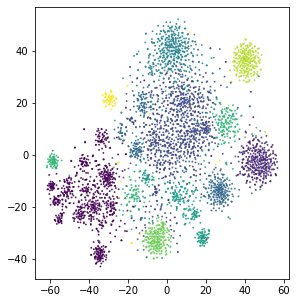

In [10]:
from sklearn.manifold import TSNE
import pandas as pd
data = pd.DataFrame(embedding.detach().cpu())
mat = data.values.astype(float)
X_tsne = TSNE(n_components=2,random_state=33).fit_transform(mat)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.figure(figsize=(10, 5))
plt.subplot(121)

scat=plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = true_label, label="t-SNE", s=0.8, alpha = 0.8)

In [10]:
result

[0.7272, 0.8017, 0.4882, 0.5001, 0.5235, 0.7009, 0.6751, 0.9818, 0.665, 0.4954]

In [11]:
sum(result)/len(result)

0.65589

In [12]:
import matplotlib.pyplot as plt
def draw_fig(list1, list2, epoch):
    x1 = range(1, epoch+1)
    y1 = list1
    y2 = list2
    plt.cla()
    plt.title('loss vs. epoch', fontsize=20)
    plt.plot(x1, y1)
    plt.plot(x1, y2)
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.grid()
    plt.show()

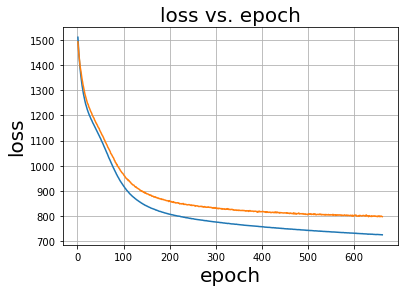

In [13]:
draw_fig(train, test, len(train))

In [12]:
a = torch.tensor([[0.1,0.2,0.7],[0.3,0.4,0.4],[0.8,0.1,0.1]])

In [13]:
index = []
for i in range(a.shape[0]):
    if a[i].max() >= 0.7:
        index.append(i)

In [14]:
index

[0, 2]

In [16]:

a = pd.DataFrame(a.detach().cpu().numpy())

In [17]:
a

,0,1,2
0,0.1,0.2,0.7
1,0.3,0.4,0.4
2,0.8,0.1,0.1


In [18]:
a = a.loc[index]

In [19]:
a

,0,1,2
0,0.1,0.2,0.7
2,0.8,0.1,0.1
